In [1]:
import sys
sys.path.append('..')

In [5]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt

from datasets.sequence_folders import SequenceFolder
from utils import tensor2array

import radar

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


'TITAN V'

(1, 501, 501)


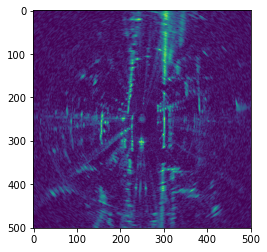

In [12]:
%matplotlib inline
base = '/mnt/datasets/yasin/robotcar/2019-01-10-14-36-48-radar-oxford-10k-partial/radar/'
tgt_im = load_img_as_float(base+'1547131046606586.png')
src_im = load_img_as_float(base+'1547131046353776.png')

print(tgt_im.shape)
plt.imshow(tgt_im[0])

In [19]:
tgt = torch.Tensor(tgt_im).to(device)
src = torch.Tensor(src_im).to(device)
tgt = tgt[None,...]
src = src[None,...]
print(tgt.shape)

torch.Size([1, 1, 501, 501])


In [14]:
# rangeResolutionsInMeter = 0.0977 # TI MMwave
rangeResolutionsInMeter = 0.175
#angleResolutionInDeg = 0.9 #deg
angleResolutionInRad = 0.015708
numRangeBins = 3768 # 256-TI, 576-Radiate, 3768-Robotcar
num_angle_bins = 400 # 64-TI


In [32]:
warper = Warper(rangeResolutionsInMeter, angleResolutionInRad, numRangeBins, num_angle_bins, 0)

In [45]:
b=1
pose = torch.tensor([0., 0, 0.785398, 10,0,0.])
print(pose.shape)
pose_batch = pose.repeat(b,1)
print(pose_batch.shape)
pose_batch = pose_batch.to(device)

torch.Size([6])
torch.Size([1, 6])


In [46]:
projected_img, valid_points = warper.inverse_warp_fft_cart(src, pose_batch)

In [49]:
print(projected_img.shape)
print(valid_points.shape)
print(valid_points.sum())

torch.Size([1, 1, 501, 501])
torch.Size([1, 1, 501, 501])
tensor(204240, device='cuda:0')


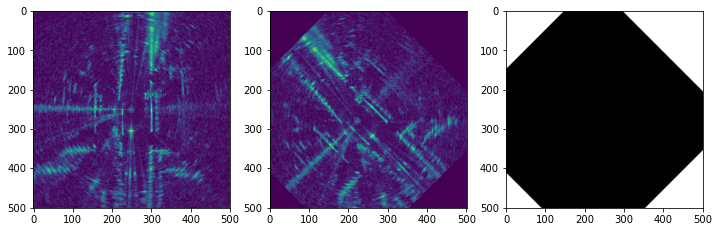

In [48]:
plt.figure(figsize=(12,16))
plt.subplot(1,3,1)
plt.imshow(src.cpu().numpy()[0,0])
plt.subplot(1,3,2)
plt.imshow(projected_img.cpu().numpy()[0,0])
plt.subplot(1,3,3)
plt.imshow(valid_points.cpu().numpy()[0,0], cmap='binary')

In [6]:
def load_img_as_float(path):
    # Resolution of the cartesian form of the radar scan in metres per pixel
    cart_resolution = .25
    # Cartesian visualisation size (used for both height and width)
    cart_pixel_width = 501  # pixels
    interpolate_crossover = True

    timestamps, azimuths, valid, fft_data, radar_resolution = radar.load_radar(str(path))
    cart_img = radar.radar_polar_to_cartesian(azimuths, fft_data, radar_resolution, cart_resolution, cart_pixel_width,
                                        interpolate_crossover)
    return cart_img

In [31]:
from __future__ import division
import torch
import torch.nn.functional as F
import torch.fft

import conversions as tgm
import loss_ssim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class Warper(object):
    """Inverse warper class
    """

    # xy_hom = None

    # def __init__(self, rangeResolutionsInMeter, angleResolutionInRad, numRangeBins, num_angle_bins,
    # with_auto_mask, padding_mode='zeros'):
    #     # RF params
    #     # rangeResolutionsInMeter = 0.0977
    #     # # dopplerResolutionMps = 0.0951
    #     # numRangeBins = 256
    #     # # numDopplerBins = 128
    #     # num_angle_bins = 64 # our choice
    #     self.rangeResolutionsInMeter=rangeResolutionsInMeter
    #     self.angleResolutionInRad = angleResolutionInRad
    #     self.numRangeBins=numRangeBins
    #     self.num_angle_bins=num_angle_bins
    #     self.with_auto_mask=with_auto_mask
    #     self.padding_mode=padding_mode

    #     azimuths = torch.arange(num_angle_bins)
    #     azimuths = (azimuths - (num_angle_bins / 2))
    #     azimuths = azimuths*angleResolutionInRad
    #     ranges = torch.arange(numRangeBins)
    #     ranges = ranges*rangeResolutionsInMeter

    #     az_grid, range_grid = torch.meshgrid(azimuths, ranges) # [num_angle_bins, numRangeBins], i.e. [W, H]
    #     x, y = pol2cart(az_grid, range_grid)
    #     x=torch.flatten(x)
    #     y=torch.flatten(y)

    #     xy = torch.vstack((x, y, torch.zeros_like(x)))  # [3,N] Augment with zero z column
    #     xy = torch.transpose(xy, 0,1) # [N,3]
    #     self.xy_hom = tgm.convert_points_to_homogeneous(xy).to(device) # [N,4]

    def __init__(self, rangeResolutionsInMeter, angleResolutionInRad, numRangeBins, num_angle_bins,
    with_auto_mask, padding_mode='zeros'):
        # RF params
        # rangeResolutionsInMeter = 0.0977
        # # dopplerResolutionMps = 0.0951
        # numRangeBins = 256
        # # numDopplerBins = 128
        # num_angle_bins = 64 # our choice
        self.cart_resolution = .25
        self.rangeResolutionsInMeter=rangeResolutionsInMeter
        self.angleResolutionInRad = angleResolutionInRad
        self.numRangeBins=numRangeBins
        self.num_angle_bins=num_angle_bins
        self.with_auto_mask=with_auto_mask
        self.padding_mode=padding_mode

        ranges_x = torch.arange(-250,251)
        ranges_x = ranges_x*self.cart_resolution
        ranges_y = torch.arange(-250,251)
        ranges_y = ranges_y*self.cart_resolution

        x, y = torch.meshgrid(ranges_x, ranges_y)
        x=torch.flatten(x)
        y=torch.flatten(y)

        xy = torch.vstack((x, y, torch.zeros_like(x)))  # [3,N] Augment with zero z column
        xy = torch.transpose(xy, 0,1) # [N,3]
        self.xy_hom = tgm.convert_points_to_homogeneous(xy).to(device) # [N,4]

    
    def radar2pixel(self, pose_mat):
        """Transform coordinates in the source frame to the target frame.
        Args:
            cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
            proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
            proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
        Returns:
            array of [-1,1] coordinates -- [B, 2, H, W]
        """
        # Transform points
        tformed_xy_hom = torch.matmul(pose_mat, torch.transpose(self.xy_hom, 0,1)) # [B,4,N]
        tformed_xy_hom = torch.transpose(tformed_xy_hom, 1,2) # [B,N,4]
        # Convert from homogenous coordinates
        tformed_xy = tgm.convert_points_from_homogeneous(tformed_xy_hom) # [B,N,3]
        # Convert back from cartesian to polar
        theta_tformed_rad, rho_tformed = cart2pol(tformed_xy[:,:,0], tformed_xy[:,:,1]) # [B,N], [B,N]
        # theta_tformed = torch.rad2deg(theta_tformed_rad) # [B,N]

        # tformed_xy = tformed_xy[:,0:2,:] # Drop augmented z column [B,2,N]
        # Replace 0-valued augmented z column with dB values of source img 
        # tformed_xy[:,2,:] = torch.flatten(img, start_dim=1) # [B,3,N] N points with x,y and db values

        X = theta_tformed_rad #theta_tformed # [B,N]
        Y = rho_tformed # [B,N]
        w = self.num_angle_bins*self.angleResolutionInRad
        h = self.numRangeBins*self.rangeResolutionsInMeter

        # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
        X_norm = 2*X/w
        Y_norm = 2*Y/h - 1  # Idem [B, H*W]

        pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
        pixel_coords = pixel_coords.reshape(self.b, self.w, self.h, 2) # [B, W, H, 2]
        pixel_coords = pixel_coords.transpose(1,2) # [B, H, W, 2]

        return pixel_coords

    
    def inverse_warp_fft(self, img, pose, rotation_mode='euler'):
        """
        Inverse warp a source radar frame to the target radar plane.
        H: Number of ADC samples (or Doppler bins)
        W: Number of angle bins
        Args:
            img: the source radar frame image (where to sample pixels) -- [B, H, W]
            pose: 6DoF pose parameters from target to source -- [B, 6]
        Returns:
            projected_img: Source image warped to the target image plane
            valid_points: Boolean array indicating point validity
        """
        check_sizes(img, 'img', 'B1HW')
        check_sizes(pose, 'pose', 'B6')

        self.b, self.c, self.h, self.w = img.size()

        assert self.w == self.num_angle_bins
        assert self.h == self.numRangeBins

        # if (xy_hom is None) or xy_hom.size(1) < 4:
        #     set_radar_grid()

        # Convert 6 DoF pose to 4x4 transformation matrix
        pose_mat = tgm.rtvec_to_pose(pose)  # T*R in homogenous coordinates [B,4,4]
        
        # src_pixel_coords = pixel_coords.reshape(b, h, w, 2)
        src_pixel_coords = self.radar2pixel(pose_mat)  # [B,H,W,2]

        projected_img = F.grid_sample(
            img, src_pixel_coords, padding_mode=self.padding_mode)

        # calculate mask values for each tformed_xy coordinates to match the target xy
        valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1 # [B,H,W]
        valid_points = torch.unsqueeze(valid_points, 1) # [B,1,H,W]

        return projected_img, valid_points

    def radar2pixel_cart(self, pose_mat):
        """Transform coordinates in the source frame to the target frame.
        Args:
            cam_coords: pixel coordinates defined in the first camera coordinates system -- [B, 4, H, W]
            proj_c2p_rot: rotation matrix of cameras -- [B, 3, 4]
            proj_c2p_tr: translation vectors of cameras -- [B, 3, 1]
        Returns:
            array of [-1,1] coordinates -- [B, 2, H, W]
        """
        # Transform points
        tformed_xy_hom = torch.matmul(pose_mat, torch.transpose(self.xy_hom, 0,1)) # [B,4,N]
        tformed_xy_hom = torch.transpose(tformed_xy_hom, 1,2) # [B,N,4]
        # Convert from homogenous coordinates
        tformed_xy = tgm.convert_points_from_homogeneous(tformed_xy_hom) # [B,N,3]

        X = tformed_xy[:,:,0] #theta_tformed # [B,N]
        Y = tformed_xy[:,:,1] # [B,N]
        w = 250*self.cart_resolution
        h = 250*self.cart_resolution

        # Normalized, -1 if on extreme left, 1 if on extreme right (x = w-1) [B, H*W]
        X_norm = X/w
        Y_norm = Y/h # Idem [B, H*W]

        pixel_coords = torch.stack([X_norm, Y_norm], dim=2)  # [B, H*W, 2]
        pixel_coords = pixel_coords.reshape(self.b, self.w, self.h, 2) # [B, W, H, 2]
        pixel_coords = pixel_coords.transpose(1,2) # [B, H, W, 2]

        return pixel_coords

    def inverse_warp_fft_cart(self, img, pose, rotation_mode='euler'):
        """
        Inverse warp a source radar frame to the target radar plane.
        H: Number of ADC samples (or Doppler bins)
        W: Number of angle bins
        Args:
            img: the source radar frame image (where to sample pixels) -- [B, H, W]
            pose: 6DoF pose parameters from target to source -- [B, 6]
        Returns:
            projected_img: Source image warped to the target image plane
            valid_points: Boolean array indicating point validity
        """
        check_sizes(img, 'img', 'B1HW')
        check_sizes(pose, 'pose', 'B6')

        self.b, self.c, self.h, self.w = img.size()

        assert self.w == 501 #self.num_angle_bins
        assert self.h == 501 #self.numRangeBins

        # if (xy_hom is None) or xy_hom.size(1) < 4:
        #     set_radar_grid()

        # Convert 6 DoF pose to 4x4 transformation matrix
        pose_mat = tgm.rtvec_to_pose(pose)  # T*R in homogenous coordinates [B,4,4]
        
        # src_pixel_coords = pixel_coords.reshape(b, h, w, 2)
        src_pixel_coords = self.radar2pixel_cart(pose_mat)  # [B,H,W,2]

        projected_img = F.grid_sample(
            img, src_pixel_coords, padding_mode=self.padding_mode)

        # calculate mask values for each tformed_xy coordinates to match the target xy
        valid_points = src_pixel_coords.abs().max(dim=-1)[0] <= 1 # [B,H,W]
        valid_points = torch.unsqueeze(valid_points, 1) # [B,1,H,W]

        return projected_img, valid_points

    #TODO: num_scales eklenebilir buraya.
    # decibels loss
    def compute_db_loss(self, tgt_img, ref_imgs, poses, poses_inv):

        rec_loss = 0
        fft_loss = 0
        ssim_loss = 0
        projected_imgs = ref_imgs

        for i, (ref_img, pose, pose_inv) in enumerate(zip(ref_imgs, poses, poses_inv)):

            rec_loss1, fft_loss1, ssim_loss1, projected_img = self.compute_pairwise_loss(tgt_img, ref_img, pose)
            rec_loss2, fft_loss2, ssim_loss2, _ = self.compute_pairwise_loss(ref_img, tgt_img, pose_inv)

            rec_loss += (rec_loss1 + rec_loss2)
            fft_loss += (fft_loss1 + fft_loss2)
            ssim_loss += (ssim_loss1 + ssim_loss2)
            projected_imgs[i] = projected_img

        return rec_loss, fft_loss, ssim_loss, projected_imgs


    def compute_pairwise_loss(self, tgt_img, ref_img, pose):

        ref_img_warped, valid_mask = self.inverse_warp_fft_cart(ref_img, pose)

        diff_img = (tgt_img - ref_img_warped).abs().clamp(0, 1)
        # diff_depth = ((computed_depth - projected_depth).abs() / (computed_depth + projected_depth)).clamp(0, 1)

        if self.with_auto_mask == True:
            auto_mask = (diff_img < (tgt_img - ref_img).abs()).float() # [B,1,H,W]
            valid_mask = auto_mask * valid_mask # element-wise # [B,1,H,W]

        # compute all loss
        reconstruction_loss = mean_on_mask(diff_img, valid_mask)
        # geometry_consistency_loss = mean_on_mask(diff_depth, valid_mask)
        # fft_loss = fft_rec_loss2(tgt_img, ref_img_warped, valid_mask)
        fft_loss = torch.Tensor([0]).to(device) # şimdilik disable

        # ssim_loss = loss_ssim.ssim(tgt_img, ref_img_warped, valid_mask)
        ssim_map = loss_ssim.ssim(tgt_img, ref_img_warped)
        diff_img = (0.15 * diff_img + 0.85 * ssim_map)
        ssim_loss = ssim_map.mean()

        return reconstruction_loss, fft_loss, ssim_loss, ref_img_warped

# compute mean value given a binary mask
def mean_on_mask(diff, valid_mask):    
    mask = valid_mask.expand_as(diff)
    if mask.sum() > 1e6*diff.shape[0]:
        mask_diff = diff * mask
        l1 = mask_diff.sum() / mask.sum()    
        # l2 = mask_diff.square().sum() / mask.sum()
    else:
        l1 = torch.tensor(1e3).float().to(device)
        # l2 = torch.tensor(0).float().to(device)
    
    l = l1 #+l2
    return l


def fft_frame(img):
    """Calculate FFT of a given image.

    Args:
        img (torch.Tensor): Image tensor. Shape [B,C,H,W]

    Returns:
        torch.Tensor: Amplitude and phase of FFT result. Shape [B,C,H,W]
    """

    fft_im = torch.fft.rfftn(img, s=img.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
    fft_amp = fft_im[...,0]**2 + fft_im[...,1]**2
    fft_amp = torch.sqrt(fft_amp) # this is the amplitude [B,C,H,W]
    fft_pha = torch.atan2( fft_im[...,1], fft_im[...,0] ) # this is the phase [B,C,H,W]

    return fft_amp, fft_pha


def fft_rec_loss(tgt, src, mask):
    """Calculate FFT loss between pair of images. The loss is masked by `mask`. FFT loss is calculated on GPU and, thus, very fast. We calculate phase and amplitude L1 losses.

    Args:
        tgt (torch.Tensor): Target image. Shape [B,C,H,W]
        src (torch.Tensor): Source image. Shape [B,C,H,W]
        mask (torch.Tensor): Boolean mask for valid points

    Returns:
        torch.Tensor: Scalar sum of phase and amplitude losses.
    """

    tgt_amp, tgt_pha = fft_frame(tgt)
    src_amp, src_pha = fft_frame(src)

    diff_amp = tgt_amp - src_amp
    # diff_amp = diff_amp*mask
    l_amp = diff_amp.abs().sum() / mask.sum()
    diff_pha = tgt_pha - src_pha
    # diff_pha = diff_pha*mask
    l_pha = diff_pha.abs().sum() / mask.sum()

    l = l_amp+l_pha
    return l

def fft_rec_loss2(tgt, src, mask):
    """Calculate FFT loss between pair of images. The loss is masked by `mask`. FFT loss is calculated on GPU and, thus, very fast. We calculate phase and amplitude L1 losses.

    Args:
        tgt (torch.Tensor): Target image. Shape [B,C,H,W]
        src (torch.Tensor): Source image. Shape [B,C,H,W]
        mask (torch.Tensor): Boolean mask for valid points

    Returns:
        torch.Tensor: Scalar sum of phase and amplitude losses.
    """

    # Apply 2D FFT on the last two dimensions, e.g., [H,W] channels.
    fft_tgt = torch.fft.rfftn(tgt, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
    fft_src = torch.fft.rfftn(src, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
    # fft_diff = torch.fft.rfftn(tgt-src, s=tgt.shape[-2:], dim=[-2,-1], norm="ortho") # [B,C,H,W,2]
    # fft_diff = fft_tgt - fft_src
    
    # fft_diff = torch.view_as_real(fft_diff)
    # mag_diff = fft_diff[...,0].abs().sum() #20*torch.log10(fft_diff[...,0]) # mag2db
    # pha_diff = fft_diff[...,1].abs().sum()
    
    # Convolution over pixels is FFT on frequencies.
    # We may find a more clever way.
    # fft_conv = fft_tgt*fft_src
    # inv_fft_conv = torch.fft.irfftn(fft_conv, s=tgt.shape[-2:], dim=[-2,-1], norm="forward") # [B,C,H,W,2]
    # mask_diff = fft_diff #fft_tgt-fft_src
    # print(mask_diff.shape)
    # print(mask.shape)
    # mask_diff = mask_diff * mask
    
    # l = 20*torch.log10(fft_diff.abs()) # mag2db 20*log10(abs(complex))

    # Derivative for angle is not implemented yet.
    # pha_diff = torch.abs(fft_tgt.angle() - fft_src.angle())
    mag_diff = torch.abs(fft_tgt.abs() - fft_src.abs())

    fft_tgt = torch.view_as_real(fft_tgt)
    fft_src = torch.view_as_real(fft_src)
    pha_tgt = torch.atan2(fft_tgt[...,1], fft_tgt[...,0])
    pha_src = torch.atan2(fft_src[...,1], fft_src[...,0])
    # mag_tgt = torch.sqrt(fft_tgt[...,1]**2 + fft_tgt[...,0]**2)
    # mag_src = torch.sqrt(fft_src[...,1]**2 + fft_src[...,0]**2)

    pha_diff = torch.abs(pha_tgt-pha_src)
    # mag_diff = torch.abs(mag_tgt - mag_src)

    # print(pha_diff.sum())
    # print(mag_diff.sum())

    l = 1e-4*mag_diff.sum() + pha_diff.sum()
    
    return l




def check_sizes(input, input_name, expected):
    condition = [input.ndimension() == len(expected)]
    for i, size in enumerate(expected):
        if size.isdigit():
            condition.append(input.size(i) == int(size))
    assert(all(condition)), "wrong size for {}, expected {}, got  {}".format(
        input_name, 'x'.join(expected), list(input.size()))



def cart2pol(x, y):
    rho = torch.sqrt(x**2 + y**2)
    phi = torch.atan2(y, x)
    return phi, rho

def pol2cart(phi, rho):
    x = rho * torch.cos(phi)
    y = rho * torch.sin(phi)
    return x, y

